In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor

EDA

In [73]:
df = pd.read_csv('data/suzuki_miyaura_data.csv')
df.replace('', np.NaN)
print(df.dtypes)
print(df.head())

reactant_1_smiles     object
reactant_2_smiles     object
catalyst_smiles       object
ligand_smiles         object
reagent_1_smiles      object
solvent_1_smiles      object
rxn                   object
yield                float64
dtype: object
                           reactant_1_smiles  \
0  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
1  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
2  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
3  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   
4  C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC   

                   reactant_2_smiles       catalyst_smiles  \
0  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
1  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
2  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
3  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   
4  CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O  CC(=O)O~CC(=O)O~[Pd]   

                             ligand_smiles reagent_1_smiles solvent_1_smiles  \
0           

In [3]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (5760, 8)
fraction of missing values in features:
ligand_smiles       0.083333
reagent_1_smiles    0.125000
dtype: float64
data types of the features with missing values:
ligand_smiles       object
reagent_1_smiles    object
dtype: object
fraction of points with missing values: 0.19791666666666666


count    5760.000000
mean        0.401095
std         0.280811
min         0.000000
25%         0.161946
50%         0.335762
75%         0.628715
max         1.000000
Name: yield, dtype: float64


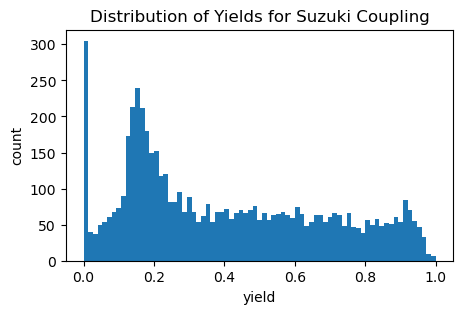

In [42]:
print(df['yield'].describe())

plt.figure(figsize=(5,3))

df['yield'].plot.hist(bins = int(np.sqrt(df.shape[0])) )  

#plt.semilogy()
plt.xlabel('yield')
plt.ylabel('count')
plt.title('Distribution of Yields for Suzuki Coupling')
plt.show()


reactant_1_smiles
C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                    1152
C1=C(Br)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                    1152
C1C2C(=NC=CC=2)C=CC=1OS(C(F)(F)F)(=O)=O.CCC1=CC(=CC=C1)CC    1152
C1=C(I)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC                     1152
C1C(B(O)O)=CC=C2N=CC=CC=12.Cl.O                               384
[B-](C1=CC2=C(C=C1)N=CC=C2)(F)(F)F.[K+].O                     384
B1(OC(C(O1)(C)C)(C)C)C2=CC3=C(C=C2)N=CC=C3.O                  384
Name: count, dtype: int64


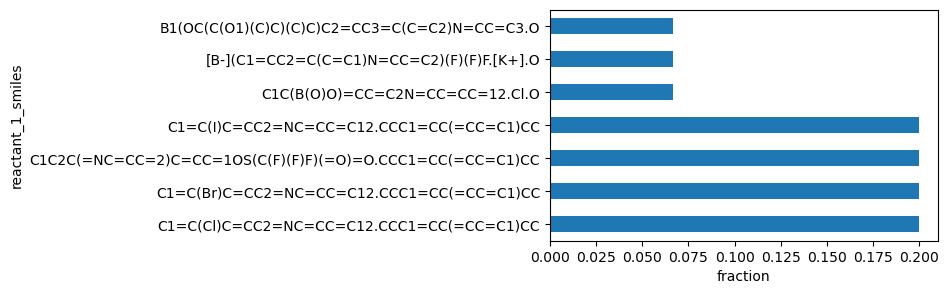

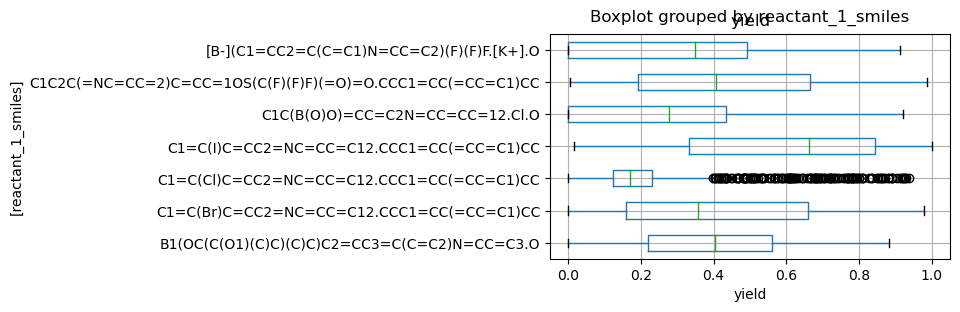

In [27]:
print(df['reactant_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reactant_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.show()

df[['yield','reactant_1_smiles']].boxplot(by='reactant_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

reactant_2_smiles
CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O                  1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4    1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]       1536
CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br                     1152
Name: count, dtype: int64


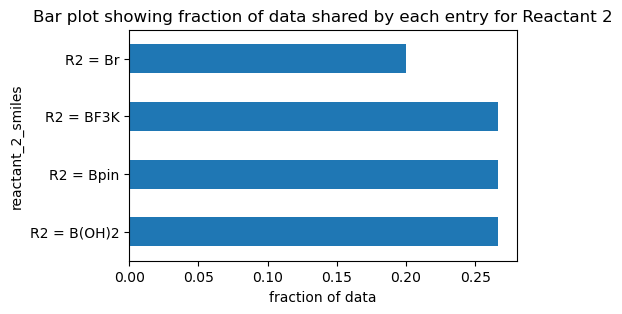

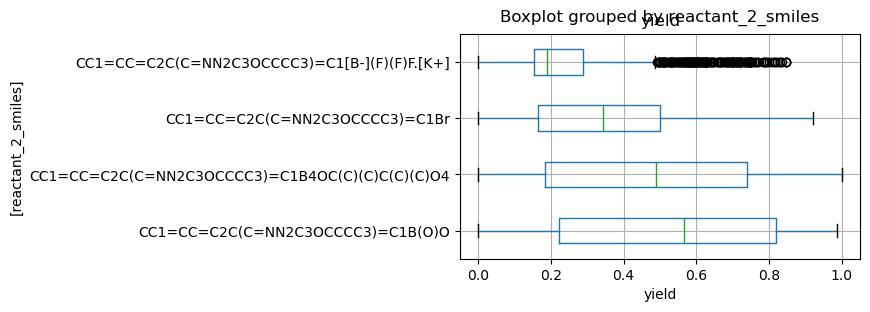

In [57]:
print(df['reactant_2_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reactant_2_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction of data')
plt.yticks([0,1,2,3],['R2 = B(OH)2', 'R2 = Bpin', 
                      'R2 = BF3K', 'R2 = Br'])
plt.title('Bar plot showing fraction of data shared by each entry for Reactant 2')
plt.show()

df[['yield','reactant_2_smiles']].boxplot(by='reactant_2_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

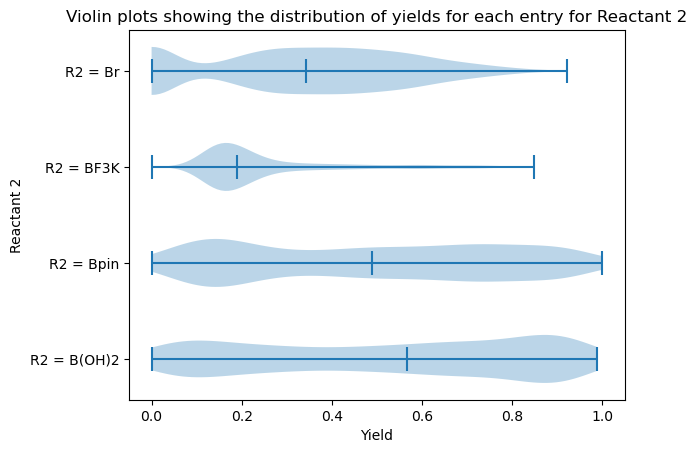

In [60]:
dataset = [df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]']['yield'].values,
           df[df['reactant_2_smiles']=='CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br']['yield'].values]

#plt.figure(figsize=(5,3))

plt.violinplot(dataset = dataset, vert=False, showmedians=True)
plt.yticks([1,2,3,4],['R2 = B(OH)2', 'R2 = Bpin', 
                      'R2 = BF3K', 'R2 = Br'])
plt.ylabel('Reactant 2')
plt.xlabel('Yield')
plt.title('Violin plots showing the distribution of yields for each entry for Reactant 2')
plt.show()

reagent_1_smiles
[OH-].[Na+]                           720
[Na+].OC([O-])=O                      720
[F-].[Cs+]                            720
[K+].[K+].[K+].[O-]P([O-])([O-])=O    720
[K+].[OH-]                            720
[Li+].[O-]C(C)(C)C                    720
CCN(CC)CC                             720
Name: count, dtype: int64


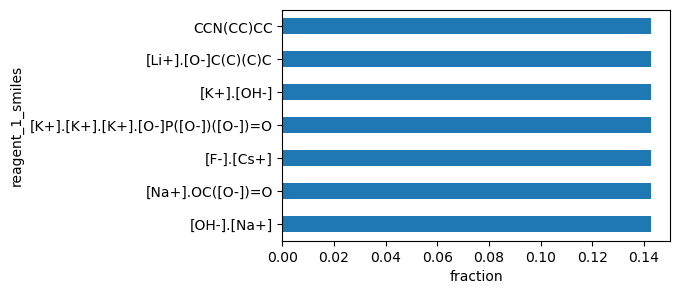

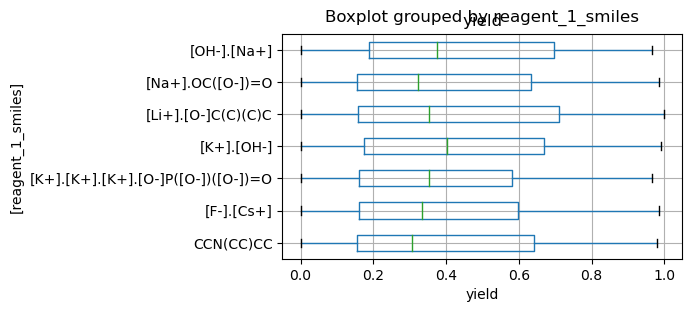

In [29]:
print(df['reagent_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['reagent_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.show()

df[['yield','reagent_1_smiles']].boxplot(by='reagent_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

ligand_smiles
CC(C)(C)P(C(C)(C)C)C(C)(C)C                                                               480
c3c(P(c1ccccc1)c2ccccc2)cccc3                                                             480
CC(C)(C)P(C1=CC=C(C=C1)N(C)C)C(C)(C)C                                                     480
C1(CCCCC1)P(C2CCCCC2)C3CCCCC3                                                             480
CC1=CC=CC=C1P(C2=CC=CC=C2C)C3=CC=CC=C3C                                                   480
CCCCP(C12CC3CC(C1)CC(C3)C2)C45CC6CC(C4)CC(C6)C5                                           480
COc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC                                                 480
CC(C)(C)P(C1=CC=C[CH]1)C(C)(C)C.CC(C)(C)P(C1=CC=C[CH]1)C(C)(C)C.[Fe]                      480
P(c2ccccc2c1c(cc(cc1C(C)C)C(C)C)C(C)C)(C3CCCCC3)C4CCCCC4                                  480
C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC=CC=C3.[Fe+2]    480
O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4cc

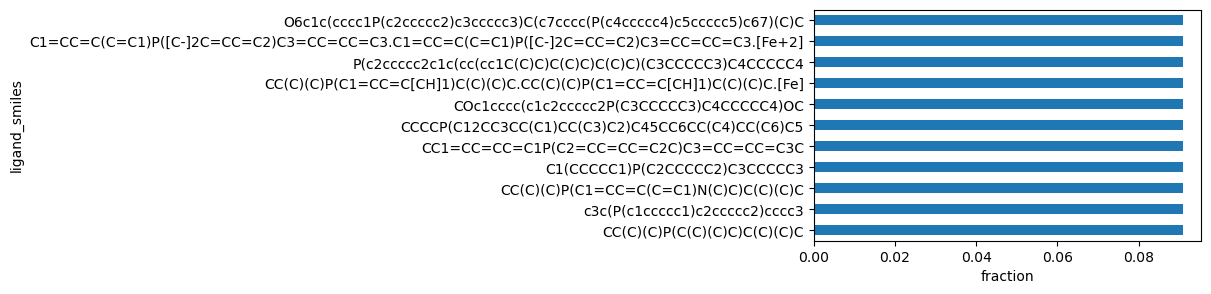

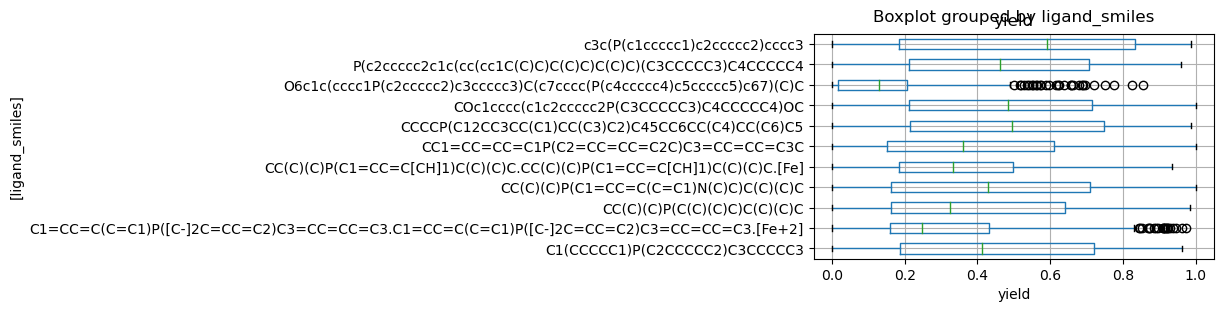

In [33]:
print(df['ligand_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['ligand_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.show()

df[['yield','ligand_smiles']].boxplot(by='ligand_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

catalyst_smiles
CC(=O)O~CC(=O)O~[Pd]    5760
Name: count, dtype: int64


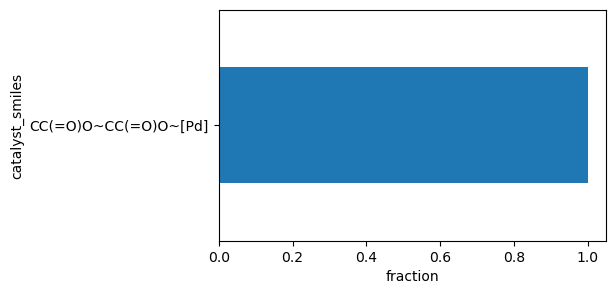

In [32]:
print(df['catalyst_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['catalyst_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.show()

#same parent catalyst used for all reactions so we cn ignore this as a feature

solvent_1_smiles
CC#N.O        1440
C1CCOC1.O     1440
CN(C)C=O.O    1440
CO.O          1440
Name: count, dtype: int64


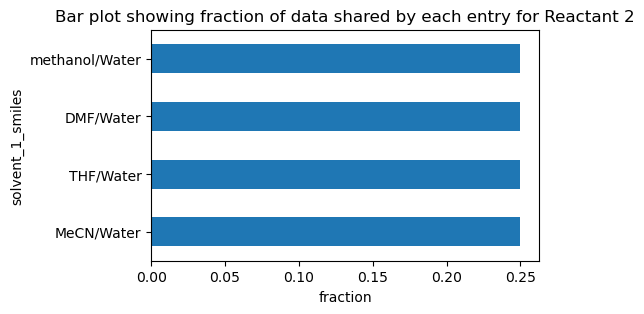

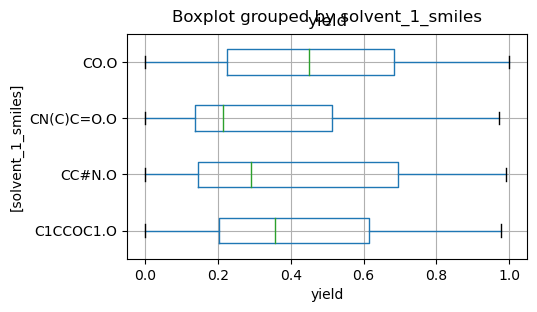

In [64]:
print(df['solvent_1_smiles'].value_counts())

plt.figure(figsize=(5,3))
pd.value_counts(df['solvent_1_smiles'],normalize=True).plot.barh()
plt.xlabel('fraction')
plt.yticks([0,1,2,3],['MeCN/Water', 'THF/Water', 
                      'DMF/Water', 'methanol/Water'])
plt.title('Bar plot showing fraction of data shared by each entry for Reactant 2')
plt.show()

df[['yield','solvent_1_smiles']].boxplot(by='solvent_1_smiles', figsize=(5,3), vert=False)
plt.xlabel('yield')
plt.show()

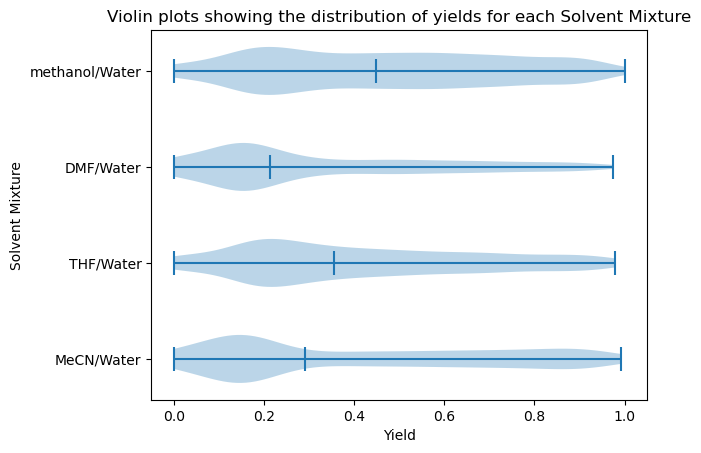

In [66]:
dataset = [df[df['solvent_1_smiles']=='CC#N.O']['yield'].values,
           df[df['solvent_1_smiles']=='C1CCOC1.O']['yield'].values,
           df[df['solvent_1_smiles']=='CN(C)C=O.O']['yield'].values,
           df[df['solvent_1_smiles']=='CO.O']['yield'].values]

#plt.figure(figsize=(5,3))

plt.violinplot(dataset = dataset, vert=False, showmedians=True)
plt.yticks([1,2,3,4],['MeCN/Water', 'THF/Water', 
                      'DMF/Water', 'methanol/Water'])
plt.ylabel('Solvent Mixture')
plt.xlabel('Yield')
plt.title('Violin plots showing the distribution of yields for each Solvent Mixture')
plt.show()

In [13]:
print(df['rxn'].value_counts())

#essentially a unique id for each combination of conditions for each reaction therefore we can drop this as a feature

rxn
CC#N.CC(=O)O~CC(=O)O~[Pd].CC(C)(C)P(C(C)(C)C)C(C)(C)C.CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1B(O)O.Clc1ccc2ncccc2c1.O.[Na+].[OH-]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                               1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                 1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.Cc1ccccc1P(c1ccccc1C)c1ccccc1C.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                             1
Brc1ccc2ncccc2c1.C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.O.[K+]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1                                                              1
Brc1ccc2ncccc2c1.CC#N.CC(=O)O~CC(=O)O~[Pd].CCc1cccc(CC)c

Splitting

Dataset is only 5760 rows, so K-fold splitting will help get the most out of the data
Categorical data is fairly balanced, so no need to carry out stratified splitting

In [74]:
#Remove the features that provide no information
df = df.drop('rxn', axis=1)
df = df.drop('catalyst_smiles', axis=1)
y = df['yield']
X = df.loc[:, df.columns != 'yield']

In [75]:
#Regular train_test_split to see how the preprocessor performs

random_state =42

X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_other,y_other,test_size = 0.25,random_state=random_state)

(4608, 5) (4608,)
test set: (1152, 5) (1152,)


In [76]:
#build the preprocessing transformer - only have categorical features
cat_ftrs = ['reactant_1_smiles', 'reactant_2_smiles', 'ligand_smiles', 'reagent_1_smiles', 'solvent_1_smiles']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='None')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_ftrs)])

In [71]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print("Preprocessed training data dimensions: {}".format(df_train.shape))

#transform the validation set
df_val = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=df_val,columns = feature_names)
print("Preprocessed validation data dimensions: {}".format(df_val.shape))

#transform the test set
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print("Preprocessed test data dimensions: {}".format(df_test.shape))
print(feature_names)

Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
['cat__reactant_1_smiles_B1(OC(C(O1)(C)C)(C)C)C2=CC3=C(C=C2)N=CC=C3.O'
 'cat__reactant_1_smiles_C1=C(Br)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1=C(Cl)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1=C(I)C=CC2=NC=CC=C12.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_C1C(B(O)O)=CC=C2N=CC=CC=12.Cl.O'
 'cat__reactant_1_smiles_C1C2C(=NC=CC=2)C=CC=1OS(C(F)(F)F)(=O)=O.CCC1=CC(=CC=C1)CC'
 'cat__reactant_1_smiles_[B-](C1=CC2=C(C=C1)N=CC=C2)(F)(F)F.[K+].O'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1B(O)O'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1B4OC(C)(C)C(C)(C)O4'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1Br'
 'cat__reactant_2_smiles_CC1=CC=C2C(C=NN2C3OCCCC3)=C1[B-](F)(F)F.[K+]'
 'cat__ligand_smiles_C1(CCCCC1)P(C2CCCCC2)C3CCCCC3'
 'cat__ligand_smiles_C1=CC=C(C=C1)P([C-]2C=CC=C2)C3=CC

In [77]:
#KFold splitting the validation and training data, and preprocessing within each individual fold.

kf = KFold(n_splits=4,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    print('Before preprocessing training set:',X_train.shape, y_train.shape) 
    print('Before preprocessing validation set:',X_val.shape, y_val.shape) 

    X_prep = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    print("Preprocessed training data dimensions: {}".format(df_train.shape))

    df_val = preprocessor.transform(X_val)
    df_val = pd.DataFrame(data=df_val,columns = feature_names)
    print("Preprocessed validation data dimensions: {}".format(df_val.shape))

    df_test = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    print("Preprocessed test data dimensions: {}".format(df_test.shape))    



Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data dimensions: (1152, 35)
Before preprocessing training set: (3456, 5) (3456,)
Before preprocessing validation set: (1152, 5) (1152,)
Preprocessed training data dimensions: (3456, 35)
Preprocessed validation data dimensions: (1152, 35)
Preprocessed test data